# Excercises 2

UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

## Copied from Part 1

In [4]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import rasterio as rio
import rasterio.plot

In [7]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

In [8]:
#We want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
%matplotlib inline

In [10]:
#Create local directory to store images
imgdir = 'LS8_sample'

#Pre-identified cloud-free Image IDs for this path/row 
#Summer 2018
img_id1 = 'LC08_L1TP_046027_20180818_20180829_01_T1'
#Winter 2018
img_id2 = 'LC08_L1TP_046027_20181224_20190129_01_T1'

In [11]:
img = img_id1

In [12]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number

#Red
r_fn = os.path.join(imgdir, img+'_B4.TIF')
#Green
g_fn = os.path.join(imgdir, img+'_B3.TIF')
#Blue
b_fn = os.path.join(imgdir, img+'_B2.TIF')
#Near-Infrared
nir_fn = os.path.join(imgdir, img+'_B5.TIF')
#Shortwave-Infrared
swir_fn = os.path.join(imgdir, img+'_B6.TIF')
#Panchromatic
p_fn = os.path.join(imgdir, img+'_B8.TIF')

In [15]:
src = rio.open(r_fn)

# Part 5: Raster window extraction

## Rasterio window
* Instead of array indexing, we can use the built-in `rasterio.windows.Window` functionality
    * This is really valuable when you only want to load a small portion of a large dataset that is too big to fit into available RAM
        * With array indexing, we must load the entire array into memory and then extract the desired window
        * With the rasterio window, we never have to load the full array
    * https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
    * Syntax is `rasterio.windows.Window(col_offset, row_offset, width, height)`
* Let's define 1024x1024 px windows around Mt. Rainer and Seattle

In [16]:
import rasterio.windows

#Mt. Rainier
window = rasterio.windows.Window(3600, 5600, 1024, 1024)

#Seattle
#window = rasterio.windows.Window(2100, 2800, 1024, 1024)

In [17]:
#Define window bounds
window_bounds = rasterio.windows.bounds(window, src.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (581385.0, 5174595.0, 612105.0, 5205315.0)
Window extent:  [581385.0, 612105.0, 5174595.0, 5205315.0]


## Define a function to read only this subwindow into an array

In [18]:
def rio2ma(fn, b=1, window=None):
    #a = None
    with rio.open(fn) as src:
        #If working with PAN, scale offset and dimensions by factor of 2
        if 'B8' in fn and window is not None:
            window = rasterio.windows.Window(window.col_off*2, window.row_off*2, window.width*2, window.height*2)
        #Read in the window to masked array
        a = src.read(b, window=window, masked=True)
        return a

## Use this function to read the Mt. Rainier window from the Panchromatic band
* Store as a new array
* Note that we get a 2048x2048 px array, due to the logic in the function above

## Display the windowed Panchromatic band with matplotlib imshow
* Use the 'gray' colormap
* Pass the `window_extent` to imshow
    * My sample code above already calculated and stored this variable for you!
* Add a scalebar

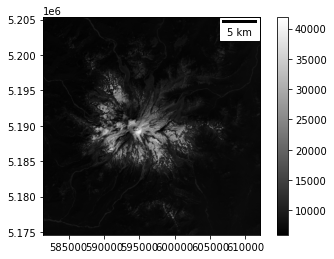

# Part 6: Contrast Enhancement
## Create a quick histogram for the window array
* This will help you visualize the range of DN values

## Write a function to normalize (AKA contrast stretch) input array values
* The input image pixel values are `UInt16` (unsigned, 16-bit integer, spanning the range 0-65535)
* We want to rescale to `float` values over the range (0.0-1.0)
    * Let's use the simple rescaling "min-max normalization" here: https://en.wikipedia.org/wiki/Feature_scaling
* So we need a function to remap the DN values from 0-65535 to 0-1
    * Simplest approach would be to map 0 -> 0 and 65535 -> 1, so just divide our original values by 65535
    * But we want to improve contrast.  
    * One option is to use the actual min and max values in the array, mapping `array.min()` -> 0 and `array.max()` -> 1
        * To do this, we need to account for an offset (`array.min()`) and scaling factor (`array.max() - array.min()`)
    * However, there could some outlier values (very bright or very dark pixels) that would set our min and max, leaving poor contrast over most valid pixels in the image. So a more robust contrast enhancement is to use the 2-98 percentile DN values as the min and max values for the rescaling step
        * The DN value of the 2nd percentile should map to 0
        * The DN value at the 98th percentile should map to 1
        * Note that we will now have some values less than 0 and some values greater than 1 in the output!
        * Optional - add a step to "clip" the remapped values, so that any values less than 0 are set to 0, and any values greater than 1 are set to 1
            * See https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html
* Your function should return a new `float` array with values distributed over the (0.0-1.0) range
* Take some time to think this through, discuss with others, and sanity check your output

## Use your function to contrast stretch the window array and plot
* You should see enchanced contrast compared to your earlier plot
* Note: the new array values are from 0-1, so if you did not `clip` values in your function, you will need to specify `vmin=0, vmax=1` in your `imshow` call to visualize your new contrast stretch

Input range: (5955, 41855)
Percentile range: (6474.0, 24048.0)
Output range: (0.0, 1.0)


masked_array(
  data=[[0.03960396, 0.03408444, 0.03766928, ..., 0.05633322, 0.0608854 ,
         0.06299078],
        [0.03232047, 0.01638785, 0.02213497, ..., 0.05724366, 0.05804029,
         0.06111301],
        [0.01900535, 0.01792421, 0.01610333, ..., 0.05866621, 0.06139752,
         0.06572209],
        ...,
        [0.02048481, 0.01616024, 0.01974508, ..., 0.06486856, 0.06134062,
         0.05553659],
        [0.0178673 , 0.01792421, 0.0204279 , ..., 0.06151132, 0.04398543,
         0.04421304],
        [0.01633094, 0.01849323, 0.01974508, ..., 0.06139752, 0.05246387,
         0.04967566]],
  mask=False,
  fill_value=999999)

Input range: (5955, 41855)
Percentile range: (6474.0, 24048.0)
Output range: (0.0, 1.0)


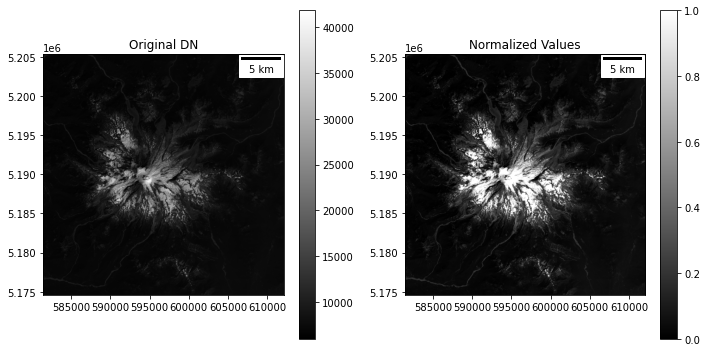

# Part 7: Composite images
* https://gsp.humboldt.edu/OLM/Courses/GSP_216_Online/lesson3-1/composites.html

## Create a natural "true-color" RGB (red, green, blue) composite for this window
* This represents "true" color, closer to what your eye would see
* Use the `rio2ma` function to load the same window from the red, green and blue band tif files
    * ⚠️ Make sure you pass in the window, and don't try to load the full images here!  Can potentially fill RAM on your Jupyterhub server, leading to kernel restart!
* Then normalize each channel independently using your `norm` function
* Use numpy `dstack` to combine as a 3D array
    * https://numpy.org/doc/stable/reference/generated/numpy.dstack.html
    * Be careful of the band order here!
    * Sanity check: final array shape should be (1024, 1024, 3)

## Plot the natural color composite
* Pass the 3-band array to `imshow`
    * Because this is such a common image format (just think about all of the RGB photos of cats on the web), `imshow` can recognize this as a 3-band array and plot, assuming values are red, green, and blue channels!
    * See doc here for (M, N, 3) array input: https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html
* Define the `extent` and add a scalebar
* Things should start to look more normal:
    * Trees should appear dark green
    * Snow: white
    * Exposed glacier ice: light blue
    * Exposed rock (or debris-covered ice): brown

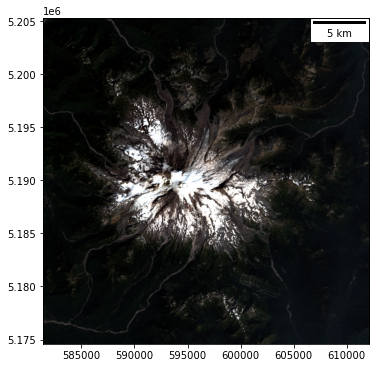

## Create a color-infrared (CIR) composite and plot
* Load the same window from the Near-IR band
* Look up the band combination required here and be careful with order passed to `dstack`
    * https://gsp.humboldt.edu/OLM/Courses/GSP_216_Online/lesson3-1/composites.html
* Sanity check: vegetation should appear red
    * Deciduous (leafy) vefetation will appear bright red
    * Coniferous (evergreen) vegetation will appear darker red

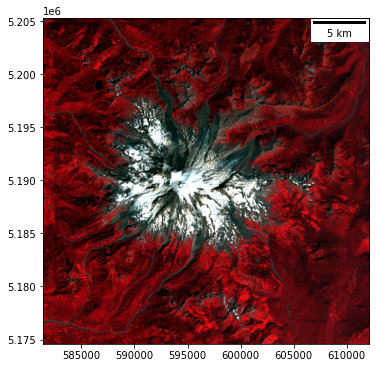

## Create a combined figure with subplots for PAN, RGB composite, and CIR composite
* Use the `plt.subplots()` with appropriate number of rows and columns
    * https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html
    * Use the `sharex` and `sharey` options - this will "link" the extent of the three subplots, so if you zoom/pan in one, the others will update to match!
        * Note how extraneous tick labels are dropped here
    * Set an appropriate `figsize` in inches - something like (12,4) might work
* Pass the projected bounds to each imshow `extent` option
* Use `gray` colormap for the PAN, you shouldn't need to specify a colormap for the RGB or CIR
* Add a scalebar to the first plot
* Add appropriate titles to each subplot
* Use `plt.tight_layout()` to clean up axes: https://matplotlib.org/tutorials/intermediate/tight_layout_guide.html

Input range: (5955, 41855)
Percentile range: (6474.0, 24048.0)
Output range: (0.0, 1.0)


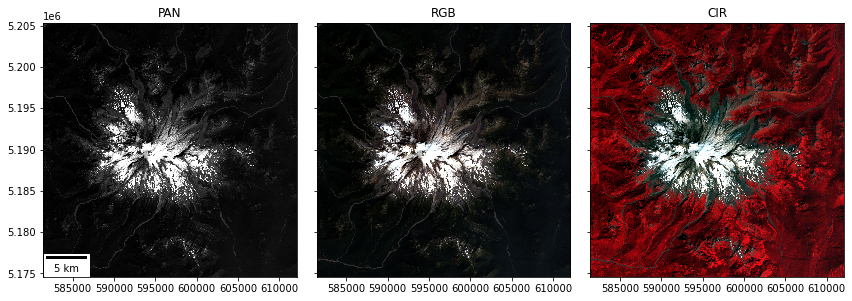

## Interactive Analysis
* You made this beautiful plot, now explore a bit!
* If you're not using already, switch to `%matplotlib widget` backend and rerun the above cell to create an interactive version of the PAN/RGB/CIR plot
* Zoom all the way in until you see individual pixels
    * Note the difference in resolution between the 15-m PAN and 30-m RGB/CIR images
    * Note how the scalebar updates (sanity check your pixel sizes here of 15 m and 30 m, if incorrect, probably an issue with your `ScaleBar` or `extent`)
* Note the changing values for (x,y) coordinates and the DN value(s) in the lower right corner of your plot
    * Should be 1 value when cursor is over PAN axes, 3 values for RGB and CIR axes
    * All values should be in the range of 0-1, because you already normalized each channel
* Experiment with some different interpolation methods for `imshow` display
    * https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
    * At least try `'neareset'`, `'bilinear'`, `'bicubic'`

### Extra Credit: Create a plot comparing different interpolation methods for identifiable features
* Can zoom in on Paradise to see roads, buildings, cars/RVs
    * Here is corresponding high-resolution aerial imagery from Google: https://goo.gl/maps/YaUWLTXZBf7vTukYA
* Note how interpolation method affects your ability to resolve features in the images 
* This sample code might be useful (though you don't have do all of these, maybe pick  a subset): https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
    * Note `'none'`, `'None'` and `'nearest'` are identical

In [36]:
#Paradise area with roads, parking lots, buildings
subwindow = rgb[700:800,450:550]
subwindow = p[1525:1625,925:1025]

# Part 8: Raster band math and index ratios
* Let's use some common band ratios to classify vegetation, snow and water for our window
* NOTE: if you're using `UInt16` masked arrays here, you will want to first convert each to `float`, as some addition/subtraction operations could result in values outside of 0-65536 (e.g., areas that are bright in all visible bands, like snow).
    * Can use `myarray.astype(float)` for this
    * If you don't do this, you will end up with "wrapping" artifacts

In [38]:
#These should already be loaded
nir = nir.astype(float)
r = r.astype(float)
g = g.astype(float)

In [39]:
#Load and convert the swir channel as well
swir = rio2ma(swir_fn, window=window)
swir = swir.astype(float)

## Compute NDVI (normalized difference vegetation index)
* Resources:
    * https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index
    * https://eos.com/ndvi/
* Create a new array to store the computed NDVI from the bands you've already loaded
* This should be a simple one-liner, basic raster band math
    * Compute the ratio using the original band values (not normalized values)
* Plot and inspect
    * Plot original ndvi
    * Plot contrast-stretched ndvi using your normalization function above
    * Do you see different NDVI values for dense conifer trees (most of the scene) vs. open meadows or recently logged plots dominated by grass and other deciduous plants?

Input range: (-0.17533183401684527, 0.6247551454932576)
Percentile range: (-0.05212441538791986, 0.4664155743355847)
Output range: (0.0, 1.0)


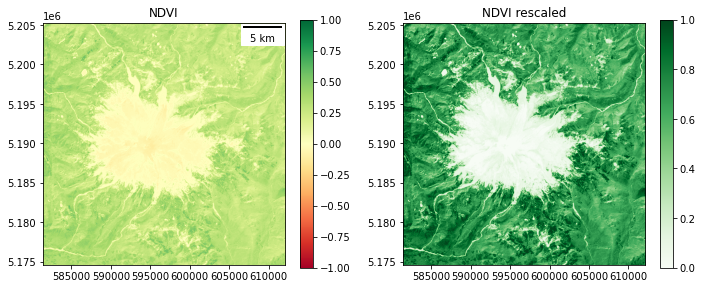

## NDSI (normalized difference snow index)
* There are multiple definitions of NDSI in the literature, but let's use this one (using SWIR, since we have it available with LS-8):
    * https://eos.com/ndsi/

Input range: (-0.4381919145474481, 0.7627169616772641)
Percentile range: (-0.23621667504351607, 0.6027555934396958)
Output range: (0.0, 1.0)


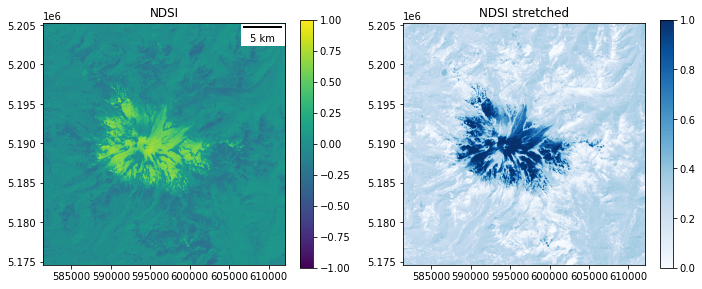

## NDWI (normalized difference water index)
* Again, multiple definitions for different sensors.  Let's use the formula for surface water bodies (not leaves):
    * https://en.wikipedia.org/wiki/Normalized_difference_water_index


Input range: (-0.5682148239484861, 0.21932790649133793)
Percentile range: (-0.41129885318841813, 0.04021959494130882)
Output range: (0.0, 1.0)


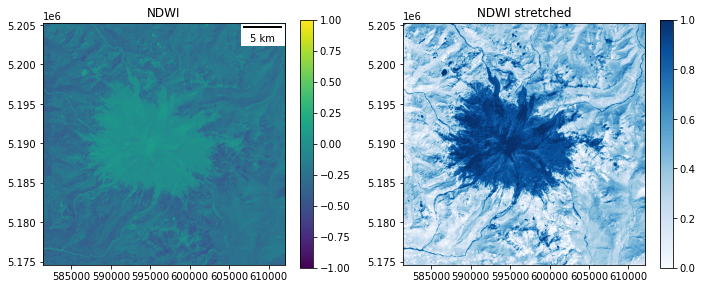

## Extra Credit: create a figure with linked RGB, CIR, NDVI, NDSI, and NDWI products
* Use the pan/zoom functionality of `%matplotlib widget` to explore the scene a bit
    * Zoom in on some vegetation, snow near the summit, and surface water like Mowich Lake (https://goo.gl/maps/V6YFJQPcfrDi9UXH6)
* Note how the different indices change (see interactive values for cursor position on each subplot), which should hopefully provide better sense of what the different indices are showing

# Part 9: Raster Classification Using Threshold
## Create a binary vegetation mask
* Need to define a cutoff value (threshold) for NDVI values to define a boolean vegetation mask
    * NDVI values above this threshold will be classified as "vegetation"
    * NDVI values below this threshold will be classified as "not vegetation"
    * This might be a useful resource: https://eos.com/ndvi/
* To decide on a threshold, probably useful review your NDVI plot above and maybe create plot a histogram of NDVI values
* Output mask should be boolean (True/False)
    * Should be true (1) for vegetation pixels and false (0) for all other pixels
* Create a figure with two subplots to show the NDVI map and your corresponding vegetation mask

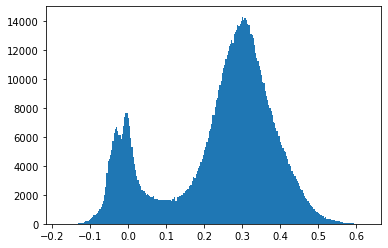

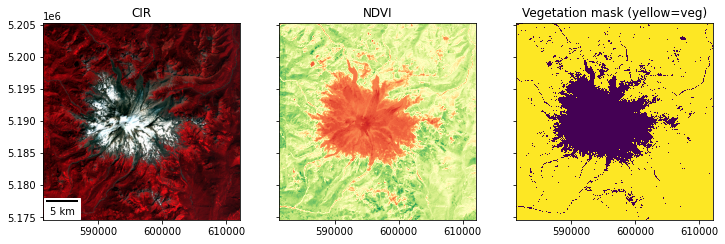

## Create a binary snow mask
* Follow a similar procedure with thresholding to create a snow mask from NDSI
* Plot a histogram and experiment with your own values until you find a threshold that looks good based on snow extent observed in RGB image

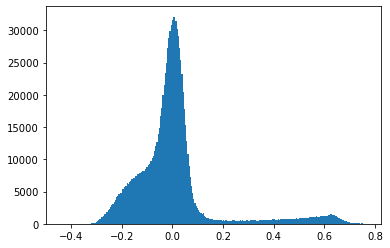

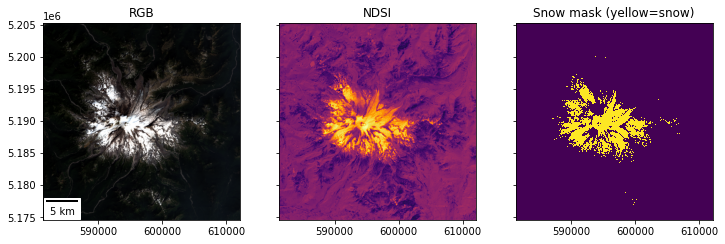

# Part 10: Raster Area Calculation

## Use your snow mask to estimate the area (km<sup>2</sup>) covered by snow
* You will need to count the number of True (1) values in your boolean snow mask
* Think about this for a moment
* Remember, that your raster is a regular grid, and you know the dimensions of each grid cell in meters
    * Start by calculating the area covered by an indvidual pixel in square meters
    * Count the number of pixels classified as snow in your boolean snow mask
        * A few ways to approach this
    * Multiply the two!
* Sanity check: make sure your estimate is consistent with expected dimensions for Mt. Rainier and your window dimensions (~30 x 30 km)
    * Hint: Snow-covered area of ~60-70 km<sup>2</sup> seems reasonable
* *Note: Based on what we learned in our earlier lab on CRS/projections, this calculation should really be done using an equal-area projection. Fine to estimate with default UTM projection here, and we will cover raster reprojection in the Raster2 lab.*

# Summary
We covered a lot of raster fundementals during this lab using a sample image from Landsat-8 over western Washington state. 

* Working with raster data in the cloud and downloading data on the fly
* Inspecting rasters with GDAL and rasterio
* Reading rasters into NumPy arrays and handling nodata
* Using the raster transform to convert between image/array and projected coordinates
* Visualizing rasters using corresponding projected coordinate system extent and scalebar
* Reading a small window from a large raster
* Raster DN value normalization and contrast enhancement
* Raster multi-band composite creation
* Raster visualization interpolation methods
* Raster band math and standardized index (e.g., NDVI) calculation 
* Raster classification using a thresholding
* Raster area calculation

All of these are common tasks in production and analysis workflows for rasters. Hopefully you can recognize the power of these simple techniques to efficiently extract meaningful quantitative information from raster data. We will revisit several of these concepts during the Raster2 lab and they will provide the foundation needed to explore `xarray` and `rioxarray`.

# Extra Credit
1. Repeat some of the above analysis for Seattle. You’ll need to redefine the window to use for extraction (this is commented out in earlier cell). Zoom in on UW campus - can you identify familiar landmarks?  Can you find your neighborhood park?
2. Repeat the above Mt. Rainier analysis for the cloud-free December 28, 2018 winter image defined early in the notebook (but not downloaded). Or identify some other cloud-free imagery to explore! 
    * Create difference maps and do some basic analysis of how NDVI and snow-covered area changed between the summer and winter images.